In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# ***data info***

In [2]:
path = "/content/drive/MyDrive/OnlineRetail.csv"
data = pd.read_csv(path , encoding="ISO-8859-1")
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [3]:
data.shape

(541909, 8)

In [4]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [7]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
data.isna().sum().sum()

136534

In [9]:
for col in data.columns :
  print(f'***********************************************************************************************{col}')
  print(f"value counts: \n{data[col].value_counts()}")
  print("----------------")
  print(f"unique data: \n{data[col].unique()}")
  print("----------------")
  print(f"n unique data: \n{data[col].nunique()}")


  print('\n\n')

***********************************************************************************************InvoiceNo
value counts: 
573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
547533       1
562135       1
553719       1
570706       1
559319       1
Name: InvoiceNo, Length: 25900, dtype: int64
----------------
unique data: 
['536365' '536366' '536367' ... '581585' '581586' '581587']
----------------
n unique data: 
25900



***********************************************************************************************StockCode
value counts: 
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
84596l       1
20850        1
90037A       1
90214U       1
35592T       1
Name: StockCode, Length: 4070, dtype: int64
----------------
unique data: 
['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']
----------------
n unique data: 
4070



******************************************************************************

#***preprocessing***

In [10]:
if data.isna().sum().sum()>0 :
  print(f'there are {data.isna().sum().sum()} nan value in dataset')
  print(f'shape : {data.shape}')
  print("dropping ...")
  data.dropna(axis=0 , inplace=True)
  print('\u2713 nan values droped')
  print(f'shape : {data.shape}')


else :
  print("\u2713 there aren't nan value in dataset")
  print(f'shape :  {data.shape}')

there are 136534 nan value in dataset
shape : (541909, 8)
dropping ...
✓ nan values droped
shape : (406829, 8)


In [11]:
data['CustomerID'] = data['CustomerID'].astype(str)
data['dates'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')


#***RFM Analysis***

    recency
    frequency
    manetory value

#####rfm df

In [12]:
# MV
data['monetory_value'] = data['UnitPrice']*data['Quantity']
# Recency
last_date = max(data['dates'])
print(f'last date base dataframe : {last_date}')

RFM = data.groupby('CustomerID').agg({'dates' : lambda x : (last_date - x.max()).days,
                                      'monetory_value' : lambda x : x.sum() ,
                                      'InvoiceNo' : lambda x: x.count()})
RFM.rename(columns={'dates' :'recency',
                    'InvoiceNo' : 'frequency'} , inplace = True)



RFM

last date base dataframe : 2011-12-09 12:50:00


,recency,monetory_value,frequency
CustomerID,,,
12346.0,325,0.00,2
12347.0,1,4310.00,182
12348.0,74,1797.24,31
12349.0,18,1757.55,73
12350.0,309,334.40,17
...,...,...,...
18280.0,277,180.60,10
18281.0,180,80.82,7
18282.0,7,176.60,13


#####rfm outliers

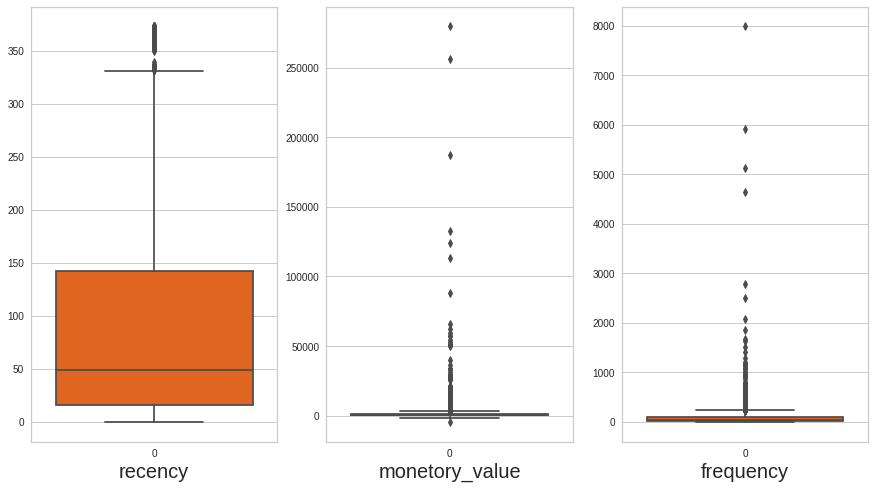

In [13]:
fig,axis = plt.subplots(1,3,figsize=(15,8))
for (i,col) in enumerate(RFM.columns):  
  sns.boxplot(data=RFM[col] , ax=axis[i] , palette="hot")
  axis[i].set_xlabel(col ,size=20)

plt.show()


In [14]:

def outlier_boundries(col):
  Q1 = np.quantile(RFM[col], q=0.05)
  Q3 = np.quantile(RFM[col], q=0.95)
  IQR = Q3 - Q1
  ourlier_step = IQR*1.5
  UR = Q3 + ourlier_step     # upper_limitation
  LR = Q1 - ourlier_step     # lower_limitation
  return UR , LR



for col in RFM.columns:
  UR , LR = outlier_boundries(col)

  RFM[col] = np.where(RFM[col]<LR , np.nan , RFM[col])
  RFM[col] = np.where(RFM[col]>UR , np.nan , RFM[col])
  


print(f'finding {RFM[col].isna().sum().sum()} statistic outlier in RFM')
print(f'rfm shape : {RFM.shape}')
print('dropping ...')
RFM.dropna(axis=0 , inplace=True)
print(f'there are {RFM[col].isna().sum().sum()} outlier in RFM')
print(f'rfm shape : {RFM.shape}')
print("**********************************")
RFM

finding 29 statistic outlier in RFM
rfm shape : (4372, 3)
dropping ...
there are 0 outlier in RFM
rfm shape : (4296, 3)
**********************************


,recency,monetory_value,frequency
CustomerID,,,
12346.0,325.0,0.00,2.0
12347.0,1.0,4310.00,182.0
12348.0,74.0,1797.24,31.0
12349.0,18.0,1757.55,73.0
12350.0,309.0,334.40,17.0
...,...,...,...
18280.0,277.0,180.60,10.0
18281.0,180.0,80.82,7.0
18282.0,7.0,176.60,13.0


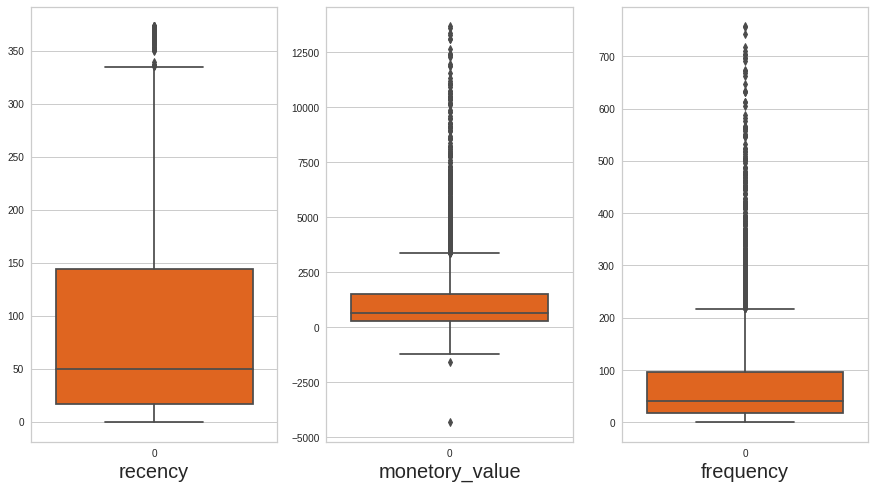

In [15]:
fig,axis = plt.subplots(1,3,figsize=(15,8))
for (i,col) in enumerate(RFM.columns):  
  sns.boxplot(data=RFM[col] , ax=axis[i] , palette='hot')
  axis[i].set_xlabel(col ,size=20)
plt.show()

In [16]:
# dendro2 = dendrogram(linkage(RFM ,metric='euclidean' ))
# plt.title("RFM")
# plt.show()

#####final rfm

    1 - turn rfm dataset to seperated value by ***quantiles*** 
    2 - turn rfm dataset to scales value by ***standardscaler*** 

In [17]:
quantile_df = RFM.quantile(q=[0.25,0.5,0.75])
quantile_df

,recency,monetory_value,frequency
0.25,17.00,289.705,17.0
0.50,50.00,633.685,40.0
0.75,144.25,1520.530,97.0


*final rfm - 1*

In [18]:
def Rclass(RFM , quantile_df , param='recency'):
  Rlist = []
  for x in RFM['recency']:
    if  quantile_df['recency'][0.25]>= x :
      Rlist.append(4)
    elif quantile_df['recency'][0.5]>= x >quantile_df['recency'][0.25]:
      Rlist.append(3)
    elif quantile_df['recency'][0.75]>= x >quantile_df['recency'][0.5]:
      Rlist.append(2)
    else:
      Rlist.append(1)
  return Rlist




def FMclass(RFM , quantile_df , param):
  Rlist = []
  for x in RFM[param]:
    if  quantile_df[param][0.25]>= x :
      Rlist.append(1)
    elif quantile_df[param][0.5]>= x >quantile_df[param][0.25]:
      Rlist.append(2)
    elif quantile_df[param][0.75]>= x >quantile_df[param][0.5]:
      Rlist.append(3)
    else:  
      Rlist.append(4)
  return Rlist

In [19]:
rfm_for_quantile = RFM.copy()

rfm_for_quantile['Recence'] = Rclass(rfm_for_quantile , quantile_df=quantile_df , param='recency')
rfm_for_quantile['Frequency'] = Rclass(rfm_for_quantile , quantile_df=quantile_df , param='frequency')
rfm_for_quantile['Monetory_Value'] = Rclass(rfm_for_quantile , quantile_df=quantile_df , param='monetory_value')


RFM_1 = rfm_for_quantile[['Recence','Monetory_Value','Frequency']]
RFM_1

,Recence,Monetory_Value,Frequency
CustomerID,,,
12346.0,1,1,1
12347.0,4,4,4
12348.0,2,2,2
12349.0,3,3,3
12350.0,1,1,1
...,...,...,...
18280.0,1,1,1
18281.0,1,1,1
18282.0,4,4,4


*final rfm -2*

In [20]:
from sklearn.preprocessing import StandardScaler

rfm_for_scaler = RFM.copy()
cols = RFM.columns

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_scaler)
rfm_df = pd.DataFrame(rfm_scaled , columns=cols)


RFM_2 = rfm_df
RFM_2

,recency,monetory_value,frequency
0,2.302422,-0.724074,-0.746158
1,-0.905954,1.727712,1.022120
2,-0.183079,0.298304,-0.461269
3,-0.737613,0.275726,-0.048671
4,2.143984,-0.533847,-0.598801
...,...,...,...
4291,1.827107,-0.621338,-0.667568
4292,0.866575,-0.678099,-0.697039
4293,-0.846540,-0.623613,-0.638096
4294,-0.886149,0.467619,6.660959


# ***modeling***

### ***1.KMeans***

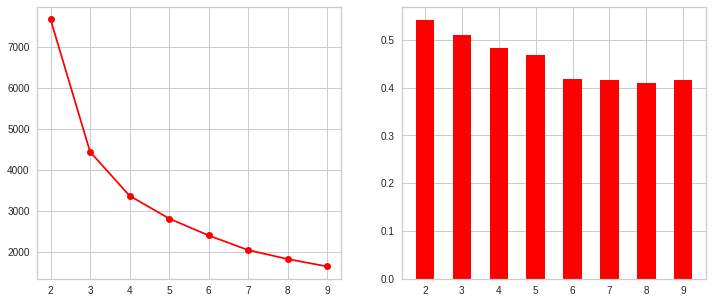

In [21]:
inertia = []
scores = {}
kmean_list = []
# elbow method
for i in range(2,10):
  kmean = KMeans(n_clusters=i)
  kmean_list.append(kmean)
  kmean.fit(RFM_2)
  inertia.append(kmean.inertia_)
  scores[i] = silhouette_score(X=RFM_2 ,labels=kmean.labels_)


f , a =plt.subplots(1,2,figsize=(12,5))
a[0].plot(range(2,len(inertia)+2),inertia , color='red' , marker='o')
a[1].bar(range(2,len(scores)+2) , list(scores.values()) , color='red' , width=0.5)
plt.show()


#####dendrogram plot

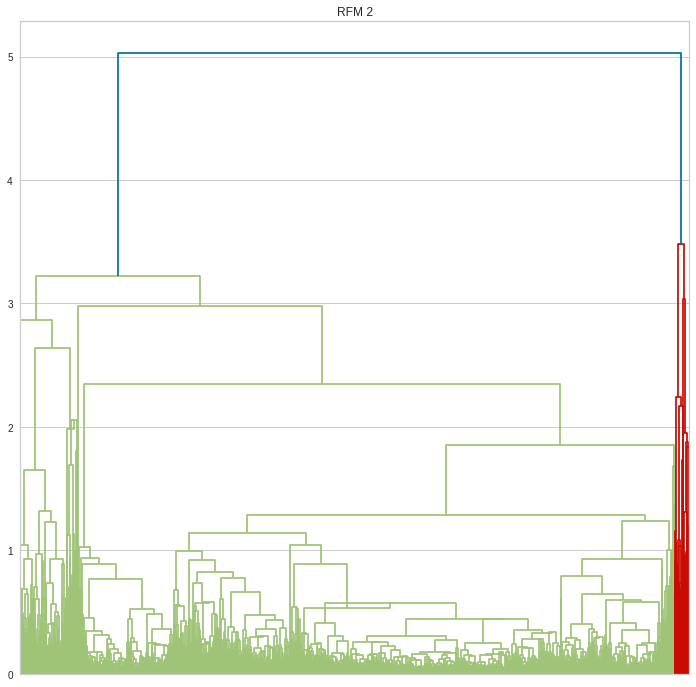

In [22]:
plt.figure(figsize=(12,12))
dendrogram = dendrogram(linkage(RFM_2 ,method='centroid',metric='euclidean' ))
plt.title("RFM 2")
plt.xticks(ticks=[])
plt.show()

#####silhouette plot

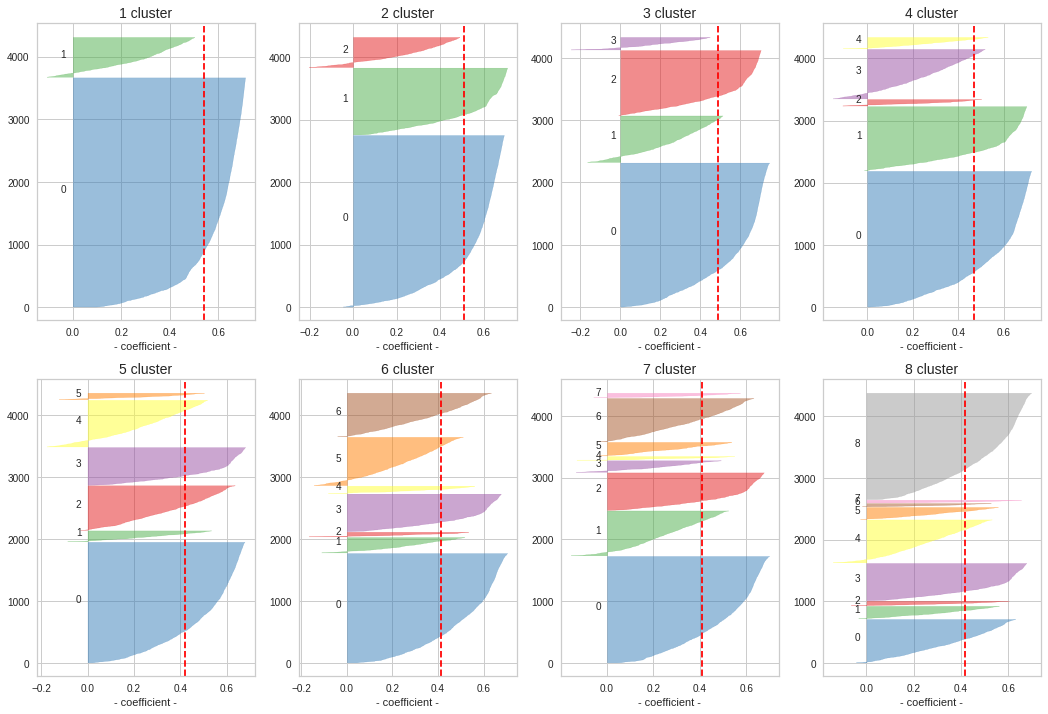

In [23]:
def silhouette_plotting(model,X):
  visualizer = SilhouetteVisualizer(model)
  plt.xlabel('- coefficient -')
  visualizer.fit(X)

f , a = plt.subplots(nrows=2 , ncols=4 , figsize=(18 , 12)) 
for (i,model) in enumerate(kmean_list):
  plt.subplot(240+i+1)
  silhouette_plotting(model=model,X=RFM_2)
  plt.title(f'{i+1} cluster' , size=14)
plt.show()

    choose n for customer clusters ------>> 3

In [24]:
final_kmean = KMeans(3)
final_kmean.fit(RFM_2)
centers = final_kmean.cluster_centers_


final_labels = final_kmean.labels_ # or ---> (fit(predict(RFM_1)))
final_labels_df = pd.DataFrame(final_labels , columns=['label'])
final_RFM = pd.concat([RFM_2 ,final_labels_df] , axis=1)
print(final_RFM['label'].value_counts())
final_RFM

0    2735
2    1068
1     493
Name: label, dtype: int64


,recency,monetory_value,frequency,label
0,2.302422,-0.724074,-0.746158,2
1,-0.905954,1.727712,1.022120,1
2,-0.183079,0.298304,-0.461269,0
3,-0.737613,0.275726,-0.048671,0
4,2.143984,-0.533847,-0.598801,2
...,...,...,...,...
4291,1.827107,-0.621338,-0.667568,2
4292,0.866575,-0.678099,-0.697039,2
4293,-0.846540,-0.623613,-0.638096,0
4294,-0.886149,0.467619,6.660959,1


In [25]:
# centers = scaler.inverse_transform(centers)
centers = pd.DataFrame(centers , columns=['x' , 'y' , 'z'])

print(f'centers loc : \n{centers}')
print(f'lenth centers : {len(centers)}')
print('\u2713')

centers loc : 
          x         y         z
0 -0.476103 -0.179556 -0.176882
1 -0.701097  2.085855  2.097533
2  1.542868 -0.503033 -0.515272
lenth centers : 3
✓


#####box plot

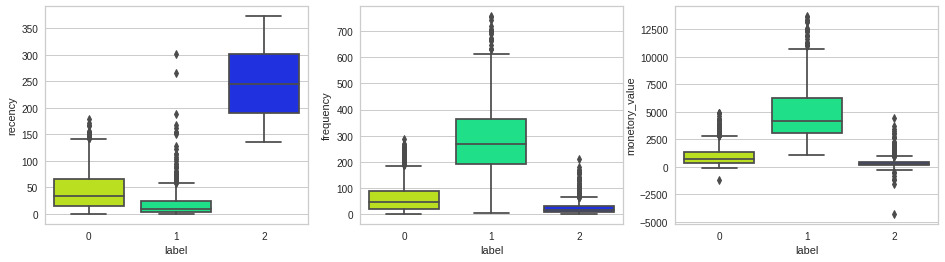

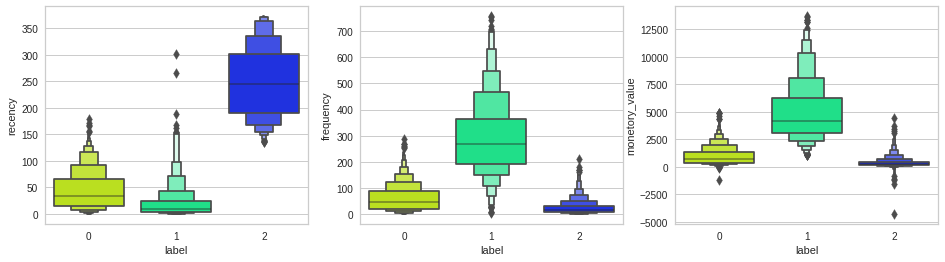

,CustomerID,recency,monetory_value,frequency,label
0,12346.0,325.0,0.00,2.0,2
1,12347.0,1.0,4310.00,182.0,1
2,12348.0,74.0,1797.24,31.0,0
3,12349.0,18.0,1757.55,73.0,0
4,12350.0,309.0,334.40,17.0,2
...,...,...,...,...,...
4291,18280.0,277.0,180.60,10.0,2
4292,18281.0,180.0,80.82,7.0,2
4293,18282.0,7.0,176.60,13.0,0
4294,18283.0,3.0,2094.88,756.0,1


In [26]:
RFM = RFM.reset_index()
RFM = pd.concat([RFM ,final_labels_df] , axis=1)


fig , ax = plt.subplots(1,3,figsize=(16,4))
sns.boxplot(ax=ax[0] ,data=RFM, y='recency' , x='label', palette='gist_rainbow')
sns.boxplot(ax=ax[1] ,data=RFM, y='frequency' , x='label',palette='gist_rainbow')
sns.boxplot(ax=ax[2] ,data=RFM, y='monetory_value' , x='label',palette='gist_rainbow')
plt.show()
print('\n')
fig , ax = plt.subplots(1,3,figsize=(16,4))
sns.boxenplot(ax=ax[0] ,data=RFM, y='recency' , x='label', palette='gist_rainbow')
sns.boxenplot(ax=ax[1] ,data=RFM, y='frequency' , x='label',palette='gist_rainbow')
sns.boxenplot(ax=ax[2] ,data=RFM, y='monetory_value' , x='label',palette='gist_rainbow')
plt.show()
print('\n\n\n')
RFM

#####scatter plot

    pca_2 ----> 2D scatter
    RFM ------> 3D scatter

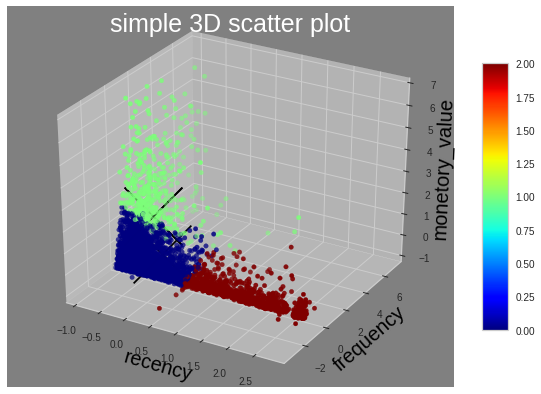

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 7))
ax =fig.add_subplot(1,1,1,projection='3d') # or # ax = Axes3D(fig)

''' 
we could use df befor standardize but should attention :
recency values * 10 for better visulization because we use the values befor standardize
and recency scale in very lower than 2 others
'''

x=RFM_2['recency']
z=RFM_2['frequency']
y=RFM_2['monetory_value']


scat = ax.scatter(x, y, z , c=RFM['label'] , cmap='jet' )
fig.colorbar(scat, ax = ax, shrink = 0.7, aspect = 10)

x0=centers.iloc[0,0]
x1=centers.iloc[1,0]
x2=centers.iloc[2,0]
X=[x0,x1,x2]

y0=centers.iloc[0,1]
y1=centers.iloc[1,1]
y2=centers.iloc[2,1]
Y = [y0,y1,y2]

z0=centers.iloc[0,2]
z1=centers.iloc[1,2]
z2=centers.iloc[2,2]
Z = [z0,z1,z2]

for i,k,j in X,Y,Z:
  ax.scatter(i,j,k, marker='x',s=3333, c='black')
'''
there are 3 centere but 2 of them are so close
'''

plt.title("simple 3D scatter plot" , size=25 , color='white')


ax.set_xlabel('recency'       ,size =20 ,color='black')
ax.set_ylabel('frequency'     ,size =20 ,color='black')
ax.set_zlabel('monetory_value',size =20 ,color='black')


ax.set_facecolor("gray")

ax.grid(True)
plt.show()



In [28]:
import plotly.express as px

fig = px.scatter_3d(RFM ,x='recency' ,y='frequency', z='monetory_value'   ,opacity=0.7,  color='label', color_discrete_map ='jet')
fig.show()